# Assignment 3

## One vs. All Classifier

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import optimize

# will be used to load MATLAB mat datafile format
import scipy.io

Import data

In [ ]:
data = scipy.io.loadmat(os.path.join('data', 'ex3data1.mat'))

Divide data and obtain dimensions

In [ ]:
X = data['X']
y = data['y'].ravel()

M = X.shape[0]
N = X.shape[1]

num_labels = len(np.unique(y)) # = 10

In [ ]:
print(y)

[10 10 10 ...  9  9  9]


Add intercept to X matrix

In [ ]:
X = np.hstack((np.ones((M, 1)), X))

Sigmoid function

In [ ]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

### Visualisation
Draw a random sample of the images we got

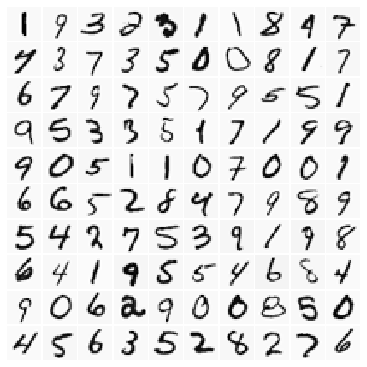

In [ ]:
dim = 10

examples = X[:, 1:][np.random.randint(M, size=dim * dim)]

"""Python version of displayData.m."""
fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in range(dim):
    for j in range(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(examples[k].reshape(int(np.sqrt(N)), int(np.sqrt(N))).T,
            cmap=plt.get_cmap('Greys'), interpolation='nearest')
        k += 1
        
plt.savefig('data/ex_3_fig_1.png', dpi=300)

### One-vs-all classifier
Method:
1. Define parameters
2. Define cost function
3. Run the optimisation function with cost function, data and parameters
    (iterate through all the different elements to classify, ie. starting with 1 up to 9)

In [ ]:
lam = 1.
theta_0 = np.zeros(N + 1)

In [ ]:
cost_history = [] # Use this array to log costs calculated in the call to scipy's "minimize" below.

def cost_function(theta, X, y, M, lam):
    """Python version of lrCostFunction.m."""
    global cost_history
    
    cost = 1 / M * (- y.dot(np.log(sigmoid(theta.dot(X.T)))) - (1 - y).dot(np.log(1 - sigmoid(theta.dot(X.T))))) \
        + lam / 2 / M * np.sum(theta[1:]**2)
    grad = 1 / M * (sigmoid(theta.dot(X.T)) - y).dot(X) + lam / M * np.hstack(([0], theta[1:]))
    
    cost_history.append(cost)
    return cost, grad

In [ ]:
cost_0, _ = cost_function(theta_0, X, y, M, lam)

print('Cost at initial theta (zeros): %.3f' % cost_0)

Cost at initial theta (zeros): 160.394


#### Train the 1's classifier

In [ ]:
y_1_hot = (y == 1).astype('float')

Run optimization with scipy function "minimize"

In [ ]:
cost_history = []

"""This call to scipy's "minimize" is a Python version of the Octave call to "fminunc".""" 
res = optimize.minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y_1_hot, M, lam), jac=True)

In [ ]:
theta = res['x']

print('Cost at best-fit theta: %.3f' % res['fun'])

Cost at best-fit theta: 0.027


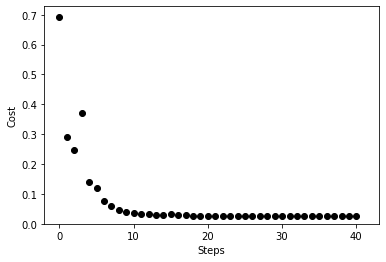

In [ ]:
num_steps = len(cost_history) 

plt.figure()
plt.scatter(np.arange(num_steps), cost_history, c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.xlim(-num_steps * 0.05, num_steps * 1.05)
plt.ylim(0, max(cost_history) * 1.05)
plt.savefig('data/ex3_plots_cost_vs_steps_train_1s.png', dpi=300)

#### Train one vs. all classifier

In [ ]:
def oneVsAll(theta_0, X, y, M, num_labels, lam):
    """Python version of oneVsAll.m."""
    all_theta = np.zeros((num_labels, N + 1))
    for i in range(1, num_labels + 1): # note that 0s are labeled with a y-value of 10 in this dataset.
        y_i_hot = (y == i).astype(np.float64)
        cost_history = [] # reset cost_history for each call to cost_function (even though cost_history not used here)
        res = optimize.minimize(cost_function, theta_0, method='L-BFGS-B', args=(X, y_i_hot, M, lam), jac=True) 
        all_theta[i - 1] = res['x']
    return all_theta

In [ ]:
all_theta = oneVsAll(theta_0, X, y, M, num_labels, lam)

#### Run prediction using the optimised theta parameters

In [ ]:
def prediction(all_theta, X):
    """Python version of predictOneVsAll.m."""
    return sigmoid(all_theta.dot(X.T)).T.argmax(axis=1) + 1

def accuracy(all_theta, X, y, M):
    return np.mean(prediction(all_theta, X) == y)

In [ ]:
print('Train Accuracy: %.4f' % accuracy(all_theta, X, y, M))

Train Accuracy: 0.9446


## Neural Networks

In [ ]:
weights = scipy.io.loadmat('data/ex3weights.mat')

theta_1 = weights['Theta1']
theta_2 = weights['Theta2']

### Feedforward propagation and prediction
Calculate hidden layer and output layer 

In [ ]:
a_2 = sigmoid(theta_1.dot(X.T))
a_2 = np.vstack((np.ones(M), a_2))

# Calculate the activations of the output layer based on the activations of the hidden layer.
a_3 = sigmoid(theta_2.dot(a_2))

In [ ]:
def nn_prediction(a_3):
    """Python version of predict.m"""
    return a_3.argmax(axis=0) + 1

def nn_accuracy(a_3):
    return np.mean(nn_prediction(a_3) == y)

In [ ]:
print('Training set accuracy: %.3f' % nn_accuracy(a_3))


Training set accuracy: 0.975


In [ ]:
nn_predictions = nn_prediction(a_3)

In [ ]:
import bqplot as bq # bqlot and IPython.display are used to create an interactive plot in the final section below
from IPython.display import display
from sklearn.linear_model import LogisticRegression # used following the first section of the notebook

In [ ]:
train_ex_num = np.random.randint(0, M)
train_ex = X[train_ex_num][1:]
train_ex = train_ex.reshape((20, 20)).T[::-1].flatten()
train_ex += abs(train_ex.min())
train_ex /= train_ex.max()

xs = bq.LinearScale()
ys = bq.LinearScale()
x_vals, y_vals = np.meshgrid(np.arange(20), np.arange(20))
scatt_1 = bq.Scatter(x=x_vals.ravel(), y=y_vals.ravel(), default_opacities=[1.0],
    scales={'x': xs, 'y': ys}, marker='square', default_colors=['white'], stroke_width=6.7)
scatt_2 = bq.Scatter(x=x_vals.ravel(), y=y_vals.ravel(), default_opacities=train_ex.tolist(),
    scales={'x': xs, 'y': ys}, marker='square', default_colors=['black'], stroke_width=6.7)
fig = bq.Figure(marks=[scatt_1, scatt_2], min_width=400, min_height=400, preserve_aspect=True, 
    title='Dataset label: %d; NN prediction: %d' % (y[train_ex_num] % 10, nn_predictions[train_ex_num] % 10))
display(fig)

Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, marks=[Scatter(colors=['steelblue'], int…

In [ ]:
train_ex_num = np.random.randint(0, M)
train_ex = X[train_ex_num][1:]
train_ex = train_ex.reshape((20, 20)).T[::-1].flatten()
train_ex += abs(train_ex.min())
train_ex /= train_ex.max()

scatt_2.default_opacities = train_ex.tolist()
fig.title = 'Dataset label: %d; NN prediction: %d' \
    % (y[train_ex_num] % 10, nn_predictions[train_ex_num] % 10)

SyntaxError: invalid syntax (<ipython-input-57-0273b12ca2ab>, line 1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18cf4704-3790-49a3-8d94-41dc8f485b71' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>